In [1]:
from utils import  get_features,get_features_salomon
import os 
DATA_DIR = r"D:\Python_D\DeepLearningAudios"
dir_audio_example = os.path.join(DATA_DIR, "audio", "fold5", "100032-3-0-0.wav")

features = get_features(dir_audio_example)
features_salomon = get_features_salomon(dir_audio_example)


d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [2]:
import pickle

# Iterar sobre los archivos y cargar cada pliegue
for i in range(1, 11):
    with open(f"data/fold_{i}.pkl", "rb") as f:
        fold_i = pickle.load(f)
        
        # Crear variables dinámicamente para cada X e y usando globals()
        globals()[f"x{i}"] = fold_i["X"]
        globals()[f"y{i}"] = fold_i["y"]
def cargar_datos(trFolds, testFolds, global_vars):
    # Crear listas para almacenar características y etiquetas para entrenamiento y prueba
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    # Recorrer los pliegues de entrenamiento y recolectar las características y etiquetas
    for fold in trFolds:
        X_train.append(global_vars[f'x{fold}'])  # Acceder a x1, x2, ..., x10
        Y_train.append(global_vars[f'y{fold}'])  # Acceder a y1, y2, ..., y10

    # Recorrer los pliegues de prueba y recolectar las características y etiquetas
    for fold in testFolds:
        X_test.append(global_vars[f'x{fold}'])  # Acceder a x1, x2, ..., x10
        Y_test.append(global_vars[f'y{fold}'])  # Acceder a y1, y2, ..., y10

    # Apilar datos de entrenamiento y prueba
    X_train = np.vstack(X_train)
    Y_train = np.concatenate(Y_train)
    X_test = np.vstack(X_test)
    Y_test = np.concatenate(Y_test)

    return X_train, Y_train, X_test, Y_test

from utils import  generate_train_set,createXtrYtr
import numpy as np
trFolds, testFolds = generate_train_set(train = 8)
X_train, y_train, X_test, y_test = cargar_datos(trFolds, testFolds, globals())

555.0


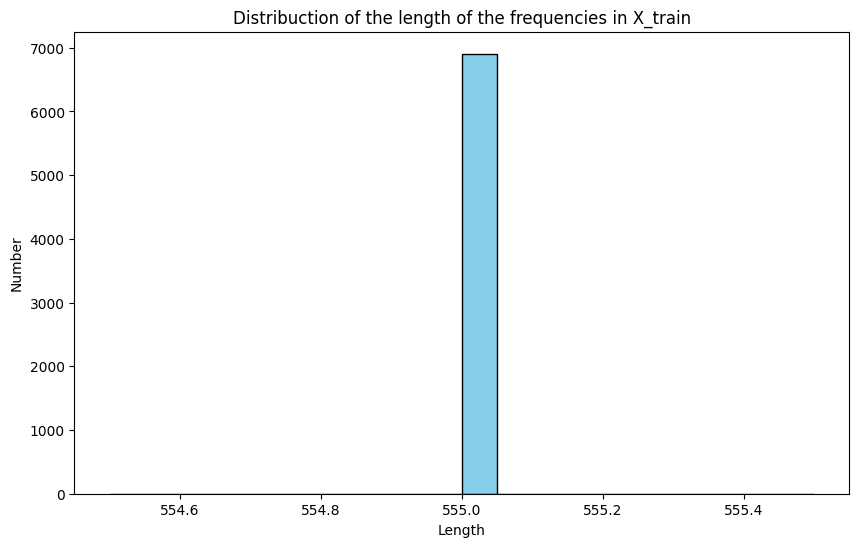

In [3]:
import matplotlib.pyplot as plt
sequence_lengths = [len(seq) for seq in X_train]
print(np.mean(sequence_lengths))
# Graficar la distribución de longitudes de las secuencias
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuction of the length of the frequencies in X_train')
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train))

# Crear el codificador de etiquetas
label_encoder = LabelEncoder()
# Ajustar y transformar las etiquetas de entrenamiento
y_train_numeric = label_encoder.fit_transform(y_train)
# Transformar las etiquetas de prueba usando el mismo codificador
y_test_numeric = label_encoder.transform(y_test)
# Convertir etiquetas de y_train y y_test a one-hot encoding
y_train = to_categorical(y_train_numeric, num_classes=num_classes)
y_test = to_categorical(y_test_numeric, num_classes=num_classes)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Mueve tus datos a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convertir tus datos numpy a tensores y moverlos a la GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Asegúrate de que y_train e y_test tengan la forma correcta para problemas de regresión/clasificación
# Por ejemplo, si son valores escalares, añade una dimensión con y.unsqueeze(-1)

# Definimos el modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Tomamos la última salida temporal
        return out

# Configuración del modelo
input_size = 555 # Características por entrada
hidden_size = 64  # Número de neuronas en la capa oculta
output_size = y_train.shape[1]  # Dimensión de la salida
num_layers = 2  # Capas de GRU
learning_rate = 0.001
num_epochs = 50

model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()  # Cambia a  si es clasificación
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluación en el conjunto de test
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor